<a href="https://colab.research.google.com/github/AyoubMDL/image-captioning/blob/main/image_captioning_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning image captioning model

In [1]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q

## Loading the dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("lambdalabs/pokemon-blip-captions")
dataset

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

## Splitting the data

In [3]:
split_dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = split_dataset["train"]
test_ds = split_dataset["test"]

## Visualization

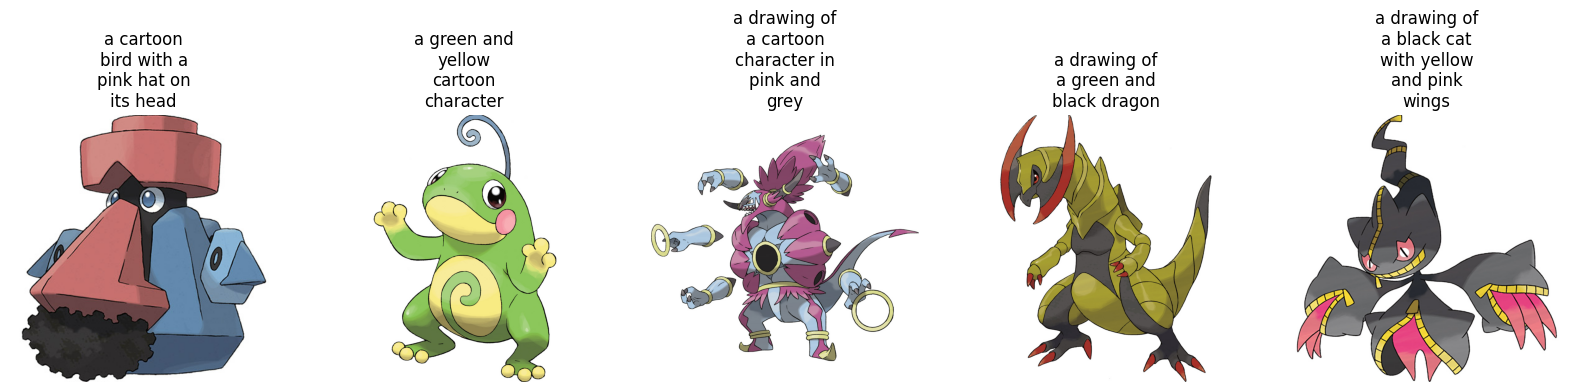

In [4]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Data processing

In [5]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

In [6]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [7]:
train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 749
})

## Modeling

In [8]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [9]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

## Training phase

In [10]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [12]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Wer Score
50,7.323600,4.413232,11.031928
100,2.114400,0.270318,0.703704
150,0.086200,0.029950,0.358876
200,0.027600,0.027458,0.362708
250,0.021500,0.025924,0.370370
300,0.017900,0.026605,1.638570
350,0.015200,0.027145,0.620690
400,0.012600,0.028539,2.553001
450,0.009800,0.027438,6.424010
500,0.007800,0.028779,6.590038


Step,Training Loss,Validation Loss,Wer Score
50,7.323600,4.413232,11.031928
100,2.114400,0.270318,0.703704
150,0.086200,0.029950,0.358876
200,0.027600,0.027458,0.362708
250,0.021500,0.025924,0.370370
300,0.017900,0.026605,1.638570
350,0.015200,0.027145,0.620690
400,0.012600,0.028539,2.553001
450,0.009800,0.027438,6.424010
500,0.007800,0.028779,6.590038


TrainOutput(global_step=2350, training_loss=0.20556389872539552, metrics={'train_runtime': 5586.8663, 'train_samples_per_second': 6.703, 'train_steps_per_second': 0.421, 'total_flos': 1.75147147865088e+16, 'train_loss': 0.20556389872539552, 'epoch': 50.0})

## Inference

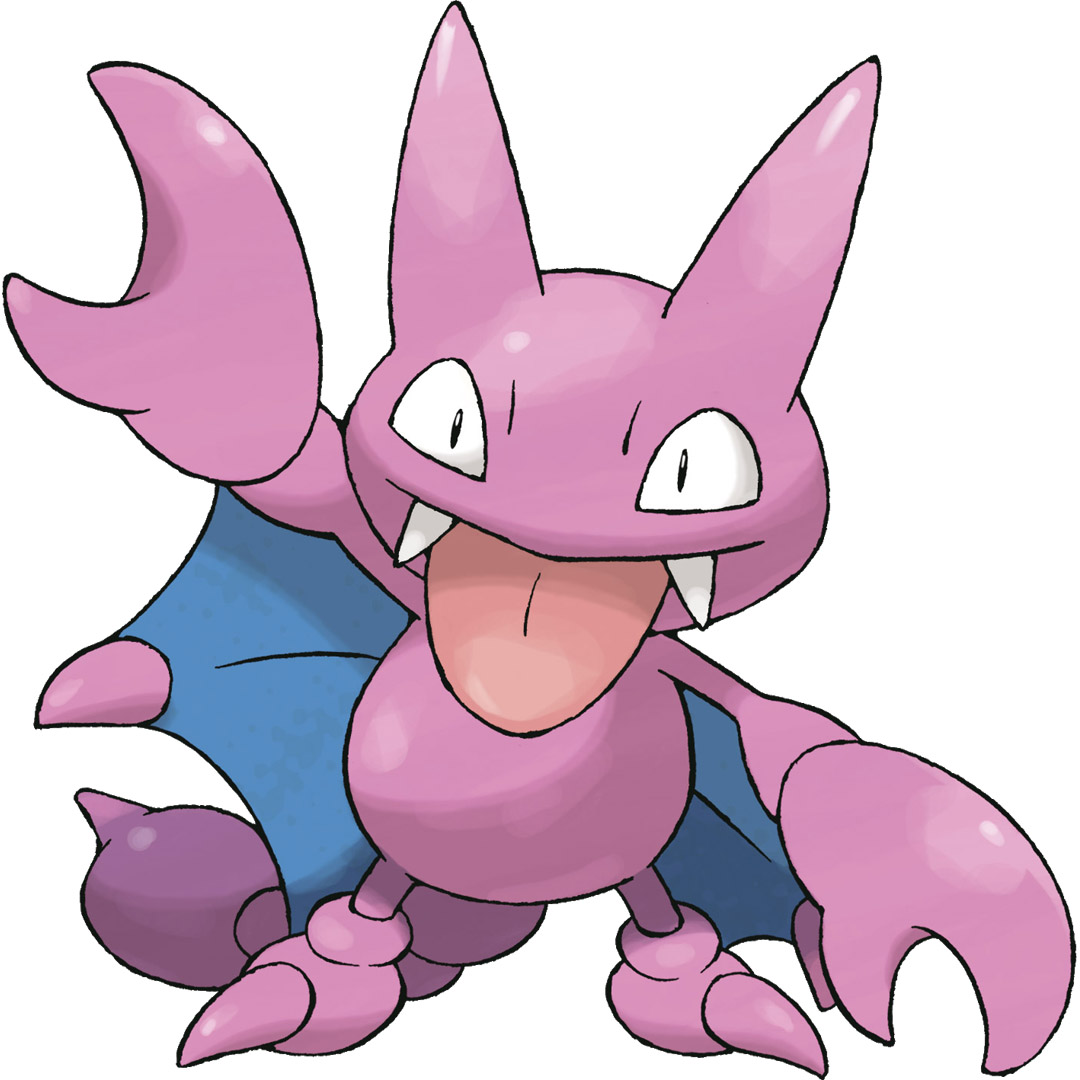

In [16]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image.show()

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [19]:
pixel_values.shape

torch.Size([1, 3, 224, 224])

In [15]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a pink and blue bird with a pink tail
